In [1]:
import os
import pandas as pd
import numpy as np
import random
import gymnasium as gym

# 1. Load Data Function
def load_mimic_data():
    # File Path Helpers
    lab_file = 'LABEVENTS.csv' if os.path.exists('LABEVENTS.csv') else 'MIMIC3/LABEVENTS.csv'
    chart_file = 'CHARTEVENTS.csv' if os.path.exists('CHARTEVENTS.csv') else 'MIMIC3/CHARTEVENTS.csv'

    # 1. Load Labs
    temp_df = pd.read_csv(lab_file, nrows=1)
    lab_usecols = [c for c in temp_df.columns if c.upper() in ['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'ITEMID', 'VALUENUM']]
    labevents = pd.read_csv(lab_file, usecols=lab_usecols)
    labevents.columns = labevents.columns.str.lower()
    labevents['charttime'] = pd.to_datetime(labevents['charttime'])

    # 2. Load Vitals (HR, MAP, SpO2)
    temp_chart = pd.read_csv(chart_file, nrows=1)
    chart_usecols = [c for c in temp_chart.columns if c.upper() in ['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'ITEMID', 'VALUENUM']]

    vitals_map = {
        211: 'hr', 220045: 'hr',
        52: 'map', 456: 'map', 220052: 'map',
        646: 'spo2', 220277: 'spo2'
    }

    vitals_list = []
    print("Loading Vitals (HR, MAP, SpO2) from ChartEvents...")
    for chunk in pd.read_csv(chart_file, chunksize=1000000, usecols=chart_usecols):
        chunk.columns = chunk.columns.str.lower()
        filtered_v = chunk[chunk['itemid'].isin(vitals_map.keys())].copy()
        filtered_v['type'] = filtered_v['itemid'].map(vitals_map)
        vitals_list.append(filtered_v)
    
    vitals = pd.concat(vitals_list)
    vitals['charttime'] = pd.to_datetime(vitals['charttime'])

    # 3. Pivot and Merge
    v_pivoted = vitals.pivot_table(index=['subject_id', 'hadm_id', 'charttime'], 
                                   columns='type', values='valuenum', aggfunc='mean')
    
    top_lab = labevents['itemid'].value_counts().index[0]
    l_pivoted = labevents[labevents['itemid'] == top_lab].pivot_table(
        index=['subject_id', 'hadm_id', 'charttime'], values='valuenum').rename(columns={'valuenum':'lab'})

    # 4. Merge and Interpolate
    merged = pd.merge(l_pivoted, v_pivoted, on=['subject_id', 'hadm_id', 'charttime'], how='outer')
    merged = merged.sort_index()
    merged = merged.groupby(level=['subject_id', 'hadm_id']).ffill()
    merged = merged.dropna()
    
    return merged

def check_data_balance(df):
    # MATCHES ENV COMPOSITE RULE:
    # Healthy if: lab in [22,29], HR in [60,100], MAP in [65,100], SpO2 >= 92
    healthy_mask = (
        (df['lab'] >= 22) & (df['lab'] <= 29) &
        (df['hr']  >= 60) & (df['hr']  <= 100) &
        (df['map'] >= 65) & (df['map'] <= 100) &
        (df['spo2'] >= 92)
    )

    total_rows = len(df)
    stable_count = int(healthy_mask.sum())
    critical_count = int(total_rows - stable_count)

    print("-" * 30)
    print("DATASET CLINICAL BALANCE (MATCHED TO ENV)")
    print("-" * 30)
    print(f"Total Time-steps: {total_rows}")
    print(f"Critical States (Needs 'Treat'): {critical_count} ({critical_count/total_rows:.1%})")
    print(f"Stable States (Needs 'Monitor'): {stable_count} ({stable_count/total_rows:.1%})")
    print("-" * 30)


# Load and Check Balance
merged_data = load_mimic_data()
check_data_balance(merged_data)

episodes = []
grouped = merged_data.groupby(level=['subject_id', 'hadm_id'])

for _, g in grouped:
    if len(g) >= 3:
        times = g.index.get_level_values('charttime')
        hours_elapsed = (times - times[0]).total_seconds() / 3600
        
        features = np.column_stack((
            g['lab'].values, 
            hours_elapsed, 
            g['hr'].values, 
            g['map'].values,
            g['spo2'].values
        )).astype(np.float32)
        episodes.append(features)

print(f"Success: Created {len(episodes)} episodes with 5 clinical features.")

Loading Vitals (HR, MAP, SpO2) from ChartEvents...
------------------------------
DATASET CLINICAL BALANCE (MATCHED TO ENV)
------------------------------
Total Time-steps: 13456
Critical States (Needs 'Treat'): 10152 (75.4%)
Stable States (Needs 'Monitor'): 3304 (24.6%)
------------------------------
Success: Created 79 episodes with 5 clinical features.


In [21]:

import gymnasium as gym
from gymnasium import spaces
import numpy as np
from typing import List, Optional, Tuple, Dict, Any


class MimicDoubleDQNEnv(gym.Env):
    """
    Gymnasium env for MIMIC-style episodes.
    Each episode is an array of shape (T, obs_dim). In your notebook: obs_dim = 5.

    Action space:
      0 = MONITOR
      1 = TREAT

    Reward (simple shaping example):
      +1 if val is in healthy_range else -1
      minus a penalty if treating when already healthy
    """

    metadata = {"render_modes": []}

    def __init__(
        self,
        episodes_list: List[np.ndarray],
        val_index: int = 0,  # which column to treat as the "val" for healthy_range (lab is 0 in your build)
        healthy_range: Tuple[float, float] = (0.0, 1.0),
        seed: Optional[int] = None,
    ):
        super().__init__()
        self.w_unhealthy = 6   # or 4.0 if still too much monitor
        self.w_healthy   = 1.0
        self.treat_cost  = 0.0   # start at 0; later try 0.02–0.1


        if episodes_list is None or len(episodes_list) == 0:
            raise ValueError("episodes_list must be a non-empty list of episode arrays.")

        # Validate + infer obs_dim
        self.episodes_list: List[np.ndarray] = []
        obs_dim: Optional[int] = None

        for i, ep in enumerate(episodes_list):
            ep = np.asarray(ep, dtype=np.float32)

            if ep.ndim != 2:
                raise ValueError(f"Episode {i} must be 2D (T, obs_dim). Got {ep.shape}.")
            if ep.shape[0] < 2:
                raise ValueError(f"Episode {i} must have at least 2 timesteps. Got T={ep.shape[0]}.")
            if obs_dim is None:
                obs_dim = int(ep.shape[1])
            elif int(ep.shape[1]) != obs_dim:
                raise ValueError(
                    f"All episodes must have the same obs_dim. Episode {i} has {ep.shape[1]} "
                    f"but expected {obs_dim}."
                )

            self.episodes_list.append(ep)

        assert obs_dim is not None
        self.obs_dim = obs_dim

        self.val_index = int(val_index)
        if not (0 <= self.val_index < self.obs_dim):
            raise ValueError(f"val_index must be in [0, {self.obs_dim-1}]. Got {self.val_index}.")

        self.healthy_low = float(healthy_range[0])
        self.healthy_high = float(healthy_range[1])
        if not (self.healthy_low < self.healthy_high):
            raise ValueError("healthy_range must satisfy low < high.")


        # Observation space: wide finite bounds (safe default)
        low = np.full((self.obs_dim,), -1e9, dtype=np.float32)
        high = np.full((self.obs_dim,), 1e9, dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.action_space = spaces.Discrete(2)

        self._rng = np.random.default_rng(seed)
        self.current_episode = self.episodes_list[0]
        self.current_step = 0

    def _get_obs(self) -> np.ndarray:
        return self.current_episode[self.current_step].astype(np.float32)
    
    def _get_normalized_obs(self, obs: np.ndarray) -> np.ndarray:
        """
        Normalise a raw 5D observation to roughly [0,1] ranges.
        Assumes obs = [lab, time_minutes, hr, map, spo2].
        """
        obs = np.asarray(obs, dtype=np.float32)

        lab  = obs[0] / 60.0
        tmin = obs[1] / 2880.0      # minutes in 48h
        hr   = obs[2] / 200.0
        map_ = (obs[3] + 10.0) / 340.0   # shift since map can be negative;  -10..330 -> 0..1
        spo2 = obs[4] / 100.0

        return np.clip(np.array([lab, tmin, hr, map_, spo2], dtype=np.float32), 0.0, 1.0)

    def _get_obs_normalized(self) -> np.ndarray:
        return self._get_normalized_obs(self._get_obs())


    def reset(self, *, seed: Optional[int] = None, options: Optional[Dict[str, Any]] = None):
        super().reset(seed=seed)
        if seed is not None:
            self._rng = np.random.default_rng(seed)

        idx = int(self._rng.integers(0, len(self.episodes_list)))
        self.current_episode = self.episodes_list[idx]
        self.current_step = 0

        obs = self._get_obs_normalized()
        info = {"episode_index": idx, "episode_len": int(self.current_episode.shape[0])}
        return obs, info

    def step(self, action: int):
        if not self.action_space.contains(action):
            raise ValueError(f"Invalid action {action}. Must be 0 or 1.")

        # Use RAW values for clinical logic / labels
        raw = self._get_obs()
        lab_raw  = float(raw[0])
        tmin_raw = float(raw[1])
        hr_raw   = float(raw[2])
        map_raw  = float(raw[3])
        spo2_raw = float(raw[4])

        # Agent still observes NORMALISED values
        obs = self._get_normalized_obs(raw)

        # ---- Composite stability rule (RAW units) ----
        lab_ok  = (22.0 <= lab_raw <= 29.0)
        hr_ok   = (60.0 <= hr_raw <= 100.0)
        map_ok  = (65.0 <= map_raw <= 100.0)
        spo2_ok = (spo2_raw >= 92.0)

        is_healthy = (lab_ok and hr_ok and map_ok and spo2_ok)

        # ---- Weighted reward (helps avoid collapse with imbalance) ----
        # If ~75% need treatment, you usually want false-negative (monitor when unhealthy)
        # to be more expensive than false-positive (treat when healthy).
        w_unhealthy = float(getattr(self, "w_unhealthy", 3.0))  # reward magnitude when unhealthy
        w_healthy   = float(getattr(self, "w_healthy",   1.0))  # reward magnitude when healthy

        if is_healthy:
            # correct: MONITOR (0)
            reward = +w_healthy if action == 0 else -w_healthy
        else:
            # correct: TREAT (1)
            reward = +w_unhealthy if action == 1 else -w_unhealthy

        # Optional small intervention cost (keep small; do NOT make it dominate)
        treat_cost = float(getattr(self, "treat_cost", 0.0))
        reward -= treat_cost * float(action)

        # advance time
        self.current_step += 1
        terminated = bool(self.current_step >= (self.current_episode.shape[0] - 1))
        truncated = False

        # next obs
        next_obs = self._get_obs_normalized() if not terminated else obs

        info = {
            # RAW (so your analysis matches clinical thresholds)
            "lab_raw": lab_raw,
            "time_min_raw": tmin_raw,
            "hr_raw": hr_raw,
            "map_raw": map_raw,
            "spo2_raw": spo2_raw,
            # Label
            "is_healthy": is_healthy,
        }
        return next_obs, float(reward), terminated, truncated, info




# Example: your episodes are (T,5). Choose which column is the "val" used for the healthy range.
# If your 'val' corresponds to HCO3, set val_index to the HCO3 column index in your 5-feature vector.
env = MimicDoubleDQNEnv(episodes_list=episodes, val_index=0, healthy_range=(22.0, 29.0))


In [3]:
# Derive a sensible healthy_range from the LAB column (col 0) to avoid nonsense bounds
all_lab = np.concatenate([ep[:, 0] for ep in episodes]).astype(np.float32)
median_lab = float(np.median(all_lab))
healthy_range = (0.8 * median_lab, 1.2 * median_lab)

env = MimicDoubleDQNEnv(
    episodes_list=episodes,
    val_index=0,  # lab column
    healthy_range=healthy_range,
    seed=0
)

# quick sanity check
obs, info = env.reset()
print("obs shape:", obs.shape, "expected:", env.observation_space.shape)


obs shape: (5,) expected: (5,)


In [22]:
import numpy as np
import torch
import torch.nn as nn

# Make sure device exists (train_ddqn uses it)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
    """
    Simple MLP Q-network: maps observation -> Q-values over discrete actions.
    Works with obs vectors of shape (obs_dim,).
    """
    def __init__(self, obs_dim: int, n_actions: int, hidden_sizes=(256, 256)):
        super().__init__()
        layers = []
        in_dim = obs_dim
        for h in hidden_sizes:
            layers += [nn.Linear(in_dim, h), nn.ReLU()]
            in_dim = h
        layers += [nn.Linear(in_dim, n_actions)]
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Accepts shape (obs_dim,) or (batch, obs_dim)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.net(x)


In [23]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity=150_000):
        self.buf = deque(maxlen=capacity)

    def add(self, s, a, r, sp, d):
        self.buf.append((s, a, r, sp, d))

    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s, a, r, sp, d = map(np.array, zip(*batch))
        return s, a, r, sp, d

    def __len__(self):
        return len(self.buf)


In [24]:
import gymnasium as gym

# Wrap your single environment into a VectorEnv
envs = gym.vector.SyncVectorEnv([lambda: env])

print("Vector env created")
print("num_envs:", envs.num_envs)
print("obs shape:", envs.single_observation_space.shape)
print("action space:", envs.single_action_space)



Vector env created
num_envs: 1
obs shape: (5,)
action space: Discrete(2)


In [25]:
import gymnasium as gym
import torch

# 1) Device (train_ddqn uses this)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Factory that creates a NEW env instance (avoid reusing the same env object)
def make_env(seed=0):
    return MimicDoubleDQNEnv(
        episodes_list=episodes,
        val_index=0,
        healthy_range=healthy_range,
        seed=seed,
    )

# 3) Keep a single env for plotting/debug if you want
env = make_env(seed=0)

# 4) Vectorized env for DDQN training (what train_ddqn expects)
envs = gym.vector.SyncVectorEnv([lambda: make_env(seed=0)])

print("Vector env created")
print("num_envs:", envs.num_envs)
print("obs shape:", envs.single_observation_space.shape)
print("action space:", envs.single_action_space)


Vector env created
num_envs: 1
obs shape: (5,)
action space: Discrete(2)


In [26]:
import numpy as np

all_obs = np.concatenate(episodes, axis=0).astype(np.float32)

lab  = all_obs[:, 0]
tmin = all_obs[:, 1]
hr   = all_obs[:, 2]
map_ = all_obs[:, 3]
spo2 = all_obs[:, 4]

lab_ok  = (22.0 <= lab) & (lab <= 29.0)
hr_ok   = (60.0 <= hr) & (hr <= 100.0)
map_ok  = (65.0 <= map_) & (map_ <= 100.0)
spo2_ok = (spo2 >= 92.0)

healthy_composite = lab_ok & hr_ok & map_ok & spo2_ok

print("Fraction healthy (COMPOSITE):", float(healthy_composite.mean()))
print("Counts:", int(healthy_composite.sum()), "/", healthy_composite.size)
print("Fraction needs_treat (COMPOSITE):", float((~healthy_composite).mean()))


Fraction healthy (COMPOSITE): 0.24554102259215219
Counts: 3304 / 13456
Fraction needs_treat (COMPOSITE): 0.7544589774078478


In [27]:
all_obs = np.concatenate(episodes, axis=0)
print("time min/max:", all_obs[:,1].min(), all_obs[:,1].max())


time min/max: 0.0 2916.1


In [10]:
counts = {"healthy": 0, "unhealthy": 0}
for _ in range(2000):
    obs, info = env.reset()
    done = False
    while not done:
        # random action just to advance
        a = env.action_space.sample()
        _, _, term, trunc, info = env.step(a)
        done = term or trunc
        if info["is_healthy"]:
            counts["healthy"] += 1
        else:
            counts["unhealthy"] += 1

total = counts["healthy"] + counts["unhealthy"]
print(counts)
print("healthy %:", counts["healthy"]/total)
print("unhealthy %:", counts["unhealthy"]/total)


{'healthy': 89901, 'unhealthy': 262374}
healthy %: 0.2552011922503726
unhealthy %: 0.7447988077496274


In [28]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm   # ### NEW

def train_ddqn(
    envs,
    total_timesteps=30_000,
    learning_starts=2_000,
    batch_size=128,
    gamma=0.99,
    lr=1e-3,
    target_update_interval=2_000,
    buffer_size=150_000,
    eps_start=1.0,
    eps_end=0.02,
    eps_fraction=0.6,
):
    obs_dim = envs.single_observation_space.shape[0]
    n_actions = envs.single_action_space.n

    q = QNetwork(obs_dim, n_actions).to(device)
    q_target = QNetwork(obs_dim, n_actions).to(device)
    q_target.load_state_dict(q.state_dict())

    opt = optim.Adam(q.parameters(), lr=lr)
    rb = ReplayBuffer(capacity=buffer_size)

    obs, _ = envs.reset()
    obs = obs.astype(np.float32)

    eps_decay_steps = int(total_timesteps * eps_fraction)
    episodic_returns = []
    ep_ret = 0.0

    # ---------- PROGRESS BAR ----------
    pbar = tqdm(total=total_timesteps, desc="Training DDQN", ncols=110)
    # ----------------------------------

    for t in range(1, total_timesteps + 1):

        # epsilon schedule
        if t <= eps_decay_steps:
            eps = eps_start + (eps_end - eps_start) * (t / eps_decay_steps)
        else:
            eps = eps_end

        # action selection
        if np.random.rand() < eps:
            actions = np.array([envs.single_action_space.sample()])
        else:
            with torch.no_grad():
                qvals = q(torch.tensor(obs, device=device))
                actions = torch.argmax(qvals, dim=1).cpu().numpy()

        next_obs, rewards, terms, truncs, infos = envs.step(actions)
        done = np.logical_or(terms, truncs)

        rb.add(obs[0], actions[0], rewards[0], next_obs[0], done[0])

        obs = next_obs.astype(np.float32)
        ep_ret += float(rewards[0])

        if done[0]:
            episodic_returns.append(ep_ret)
            ep_ret = 0.0
            obs, _ = envs.reset()
            obs = obs.astype(np.float32)

        # learning
        if len(rb) >= learning_starts:
            sb, ab, rbw, spb, db = rb.sample(batch_size)

            sb_t  = torch.tensor(sb, dtype=torch.float32, device=device)
            ab_t  = torch.tensor(ab, dtype=torch.int64, device=device).unsqueeze(1)
            rb_t  = torch.tensor(rbw, dtype=torch.float32, device=device).unsqueeze(1)
            spb_t = torch.tensor(spb, dtype=torch.float32, device=device)
            db_t  = torch.tensor(db.astype(np.float32), device=device).unsqueeze(1)

            q_sa = q(sb_t).gather(1, ab_t)

            # Double DQN target
            next_a = torch.argmax(q(spb_t), dim=1, keepdim=True)
            next_q = q_target(spb_t).gather(1, next_a)
            y = rb_t + gamma * (1.0 - db_t) * next_q

            loss = F.smooth_l1_loss(q_sa, y.detach())
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(q.parameters(), 10.0)
            opt.step()

            if t % target_update_interval == 0:
                q_target.load_state_dict(q.state_dict())

        # ---------- UPDATE PROGRESS BAR ----------
        if t % 50 == 0 or done[0]:
            pbar.set_postfix({
                "eps": f"{eps:.3f}",
                "buffer": len(rb),
                "episodes": len(episodic_returns),
                "last_ep_ret": f"{episodic_returns[-1]:.1f}" if episodic_returns else "—"
            })
        pbar.update(1)
        # ---------------------------------------

    pbar.close()
    return q, episodic_returns


q_model, returns = train_ddqn(envs)

print("Episodes:", len(returns))
print("Last-10 mean return:", np.mean(returns[-10:]) if len(returns) >= 10 else None)



Episodes: 170
Last-10 mean return: 496.2


In [29]:
import torch
import numpy as np

def eval_action_rate(q_model, env, n_steps=50_000):
    q_model.eval()
    device = next(q_model.parameters()).device

    counts = {0: 0, 1: 0}
    by_label = {"healthy": {0: 0, 1: 0}, "unhealthy": {0: 0, 1: 0}}

    obs, info = env.reset()
    done = False

    for _ in range(n_steps):
        x = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            a = int(torch.argmax(q_model(x), dim=1).item())

        obs, r, term, trunc, info = env.step(a)
        done = term or trunc

        counts[a] += 1
        lbl = "healthy" if info["is_healthy"] else "unhealthy"
        by_label[lbl][a] += 1

        if done:
            obs, info = env.reset()
            done = False

    total = counts[0] + counts[1]
    print("Overall:", {k: counts[k] / total for k in counts})
    for lbl in ["healthy", "unhealthy"]:
        t = by_label[lbl][0] + by_label[lbl][1]
        print(lbl + ":", {k: by_label[lbl][k] / max(t, 1) for k in [0, 1]})

eval_action_rate(q_model, env)



Overall: {0: 0.07684, 1: 0.92316}
healthy: {0: 0.3153807615230461, 1: 0.6846192384769539}
unhealthy: {0: 0.0017094466652640438, 1: 0.9982905533347359}


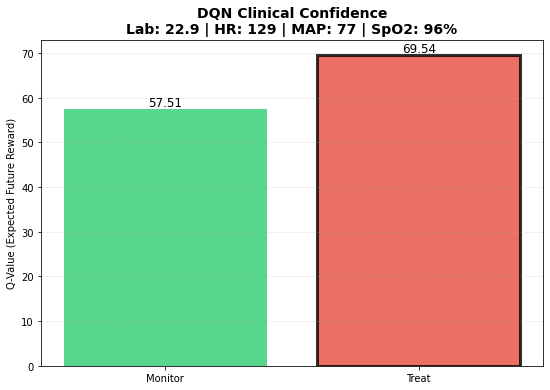

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_q_values(q_model, env, device=None):
    if device is None:
        device = next(q_model.parameters()).device

    # Reset env
    try:
        obs, _ = env.reset()
    except ValueError:
        obs = env.reset()

    obs = np.asarray(obs, dtype=np.float32)

    # Shape -> (1, obs_dim)
    if obs.ndim == 1:
        obs = obs[None, :]

    # Q-values
    with torch.no_grad():
        obs_tensor = torch.as_tensor(obs, device=device)
        q_values = q_model(obs_tensor).cpu().numpy()[0]

    # --- Denormalisation (only if your env is normalised!) ---
    raw = obs[0]
    raw_lab  = raw[0] * 60.0
    raw_time = raw[1] * 2880.0
    raw_hr   = raw[2] * 200.0
    raw_map  = raw[3] * 340.0 - 10.0
    raw_spo2 = raw[4] * 100.0


    vital_summary = (
        f"Lab: {raw_lab:.1f} | HR: {raw_hr:.0f} | "
        f"MAP: {raw_map:.0f} | SpO2: {raw_spo2:.0f}%"
    )

    # Plot
    plt.figure(figsize=(9, 6))
    colors = ['#2ecc71', '#e74c3c']
    bars = plt.bar(['Monitor', 'Treat'], q_values, color=colors, alpha=0.8)

    chosen_action = int(np.argmax(q_values))
    bars[chosen_action].set_edgecolor('black')
    bars[chosen_action].set_linewidth(3)

    plt.title(f"DQN Clinical Confidence\n{vital_summary}", fontsize=14, fontweight='bold')
    plt.ylabel("Q-Value (Expected Future Reward)")
    plt.axhline(0, color='black', lw=1)
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    for bar in bars:
        y = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            y,
            f"{y:.2f}",
            ha='center',
            va='bottom' if y > 0 else 'top',
            fontsize=12,
        )

    plt.show()

plot_q_values(q_model, env)


<ipython-input-31-3da59b682f7f>:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


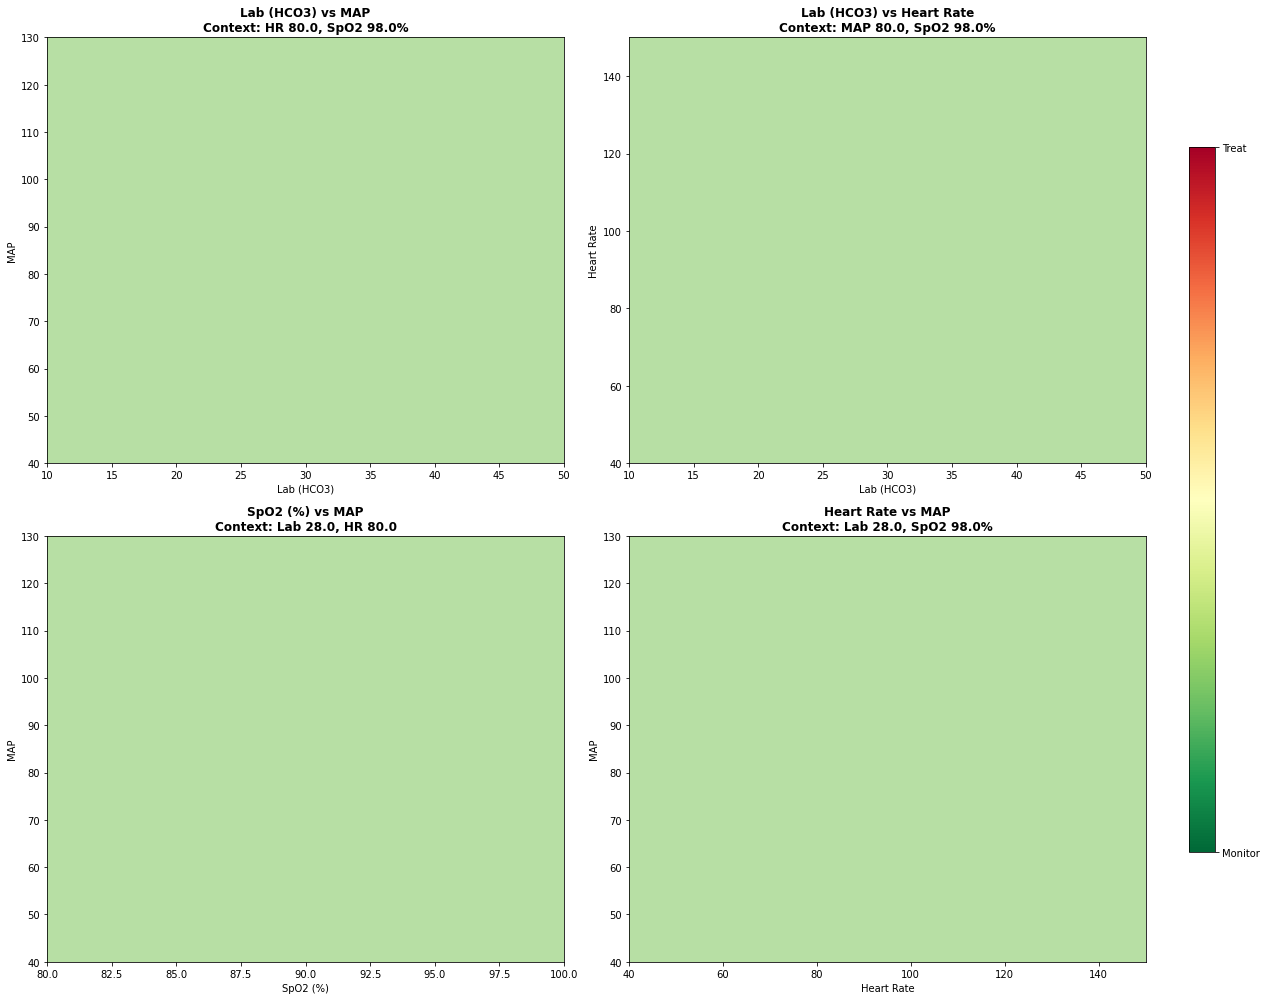

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_clinical_strategy_dashboard(q_model):
    device = next(q_model.parameters()).device
    q_model.eval()

    # ---- Figure layout ----
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()

    # ---- Clinical ranges (RAW) ----
    lab_vals  = np.linspace(10, 50, 100)    # HCO3
    map_vals  = np.linspace(40, 130, 100)   # MAP
    hr_vals   = np.linspace(40, 150, 100)   # HR
    spo2_vals = np.linspace(80, 100, 100)   # SpO2

    # ---- Baseline healthy context ----
    FIXED_TIME = 12.0
    FIXED_LAB  = 28.0
    FIXED_HR   = 80.0
    FIXED_MAP  = 80.0
    FIXED_SPO2 = 98.0

    # ---- Normalisation (MUST match training) ----
    def normalize_grid(grid):
        norm = np.zeros_like(grid, dtype=np.float32)
        norm[:, 0] = np.clip(grid[:, 0] / 60.0,  0, 1)   # Lab
        norm[:, 1] = np.clip(grid[:, 1] / 48.0,  0, 1)   # Time
        norm[:, 2] = np.clip(grid[:, 2] / 150.0, 0, 1)   # HR
        norm[:, 3] = np.clip(grid[:, 3] / 120.0, 0, 1)   # MAP
        norm[:, 4] = np.clip(grid[:, 4] / 100.0, 0, 1)   # SpO2
        return norm

    # ---- DDQN action inference ----
    def predict_actions(obs_np):
        obs_t = torch.as_tensor(obs_np, dtype=torch.float32, device=device)
        with torch.no_grad():
            q_vals = q_model(obs_t)
            return torch.argmax(q_vals, dim=1).cpu().numpy()

    # -------- Plane 1: Lab vs MAP --------
    L, M = np.meshgrid(lab_vals, map_vals)
    grid1 = np.c_[
        L.ravel(),
        np.full(L.size, FIXED_TIME),
        np.full(L.size, FIXED_HR),
        M.ravel(),
        np.full(L.size, FIXED_SPO2),
    ]
    Z1 = predict_actions(normalize_grid(grid1)).reshape(L.shape)

    # -------- Plane 2: Lab vs HR --------
    L2, H = np.meshgrid(lab_vals, hr_vals)
    grid2 = np.c_[
        L2.ravel(),
        np.full(L2.size, FIXED_TIME),
        H.ravel(),
        np.full(L2.size, FIXED_MAP),
        np.full(L2.size, FIXED_SPO2),
    ]
    Z2 = predict_actions(normalize_grid(grid2)).reshape(L2.shape)

    # -------- Plane 3: SpO2 vs MAP (Shock plane) --------
    S, M2 = np.meshgrid(spo2_vals, map_vals)
    grid3 = np.c_[
        np.full(S.size, FIXED_LAB),
        np.full(S.size, FIXED_TIME),
        np.full(S.size, FIXED_HR),
        M2.ravel(),
        S.ravel(),
    ]
    Z3 = predict_actions(normalize_grid(grid3)).reshape(S.shape)

    # -------- Plane 4: HR vs MAP --------
    H2, M3 = np.meshgrid(hr_vals, map_vals)
    grid4 = np.c_[
        np.full(H2.size, FIXED_LAB),
        np.full(H2.size, FIXED_TIME),
        H2.ravel(),
        M3.ravel(),
        np.full(H2.size, FIXED_SPO2),
    ]
    Z4 = predict_actions(normalize_grid(grid4)).reshape(H2.shape)

    # ---- Plot definitions ----
    planes = [
        (L,  M,  Z1, "Lab (HCO3)", "MAP",        f"Context: HR {FIXED_HR}, SpO2 {FIXED_SPO2}%"),
        (L2, H,  Z2, "Lab (HCO3)", "Heart Rate", f"Context: MAP {FIXED_MAP}, SpO2 {FIXED_SPO2}%"),
        (S,  M2, Z3, "SpO2 (%)",  "MAP",        f"Context: Lab {FIXED_LAB}, HR {FIXED_HR}"),
        (H2, M3, Z4, "Heart Rate","MAP",        f"Context: Lab {FIXED_LAB}, SpO2 {FIXED_SPO2}%"),
    ]

    for i, (x, y, z, xlabel, ylabel, subtitle) in enumerate(planes):
        cf = axes[i].contourf(x, y, z, cmap="RdYlGn_r", alpha=0.6)
        axes[i].set_title(f"{xlabel} vs {ylabel}\n{subtitle}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)

    # ---- Shared colour bar on the right ----
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap="RdYlGn_r"),
        cax=cax,
        ticks=[0, 1],
    )
    cbar.set_ticklabels(["Monitor", "Treat"])

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

plot_clinical_strategy_dashboard(q_model)


<ipython-input-32-0dc0106e61d0>:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


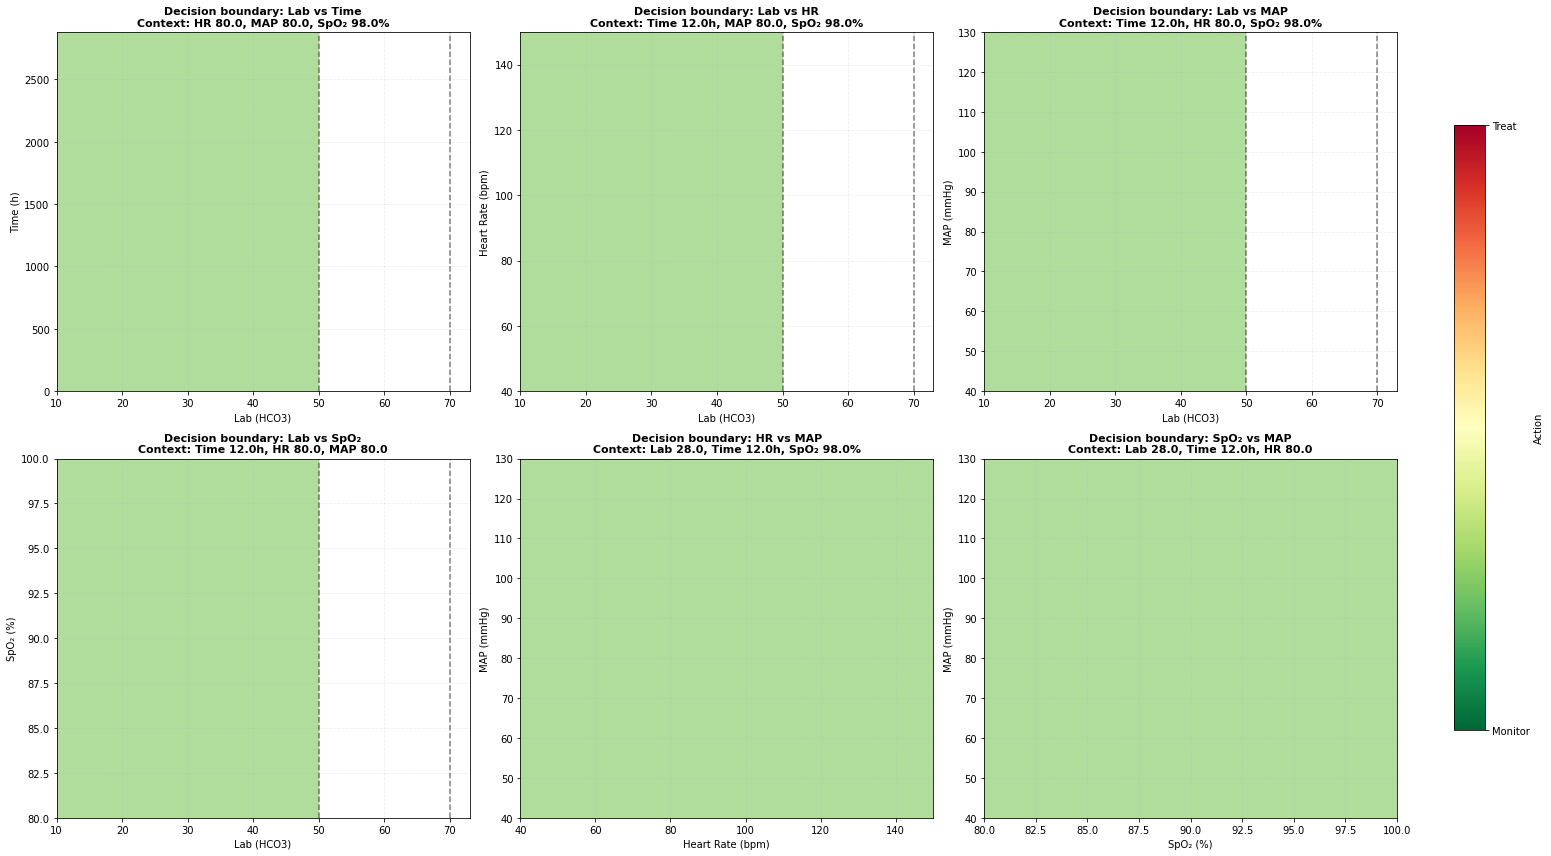

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_all_decision_boundaries(q_model):
    device = next(q_model.parameters()).device
    q_model.eval()

    # ---------- Ranges (RAW clinical units) ----------
    lab_vals  = np.linspace(10, 50, 140)     # HCO3
    time_vals = np.linspace(0, 2880, 140)  # minutes
    hr_vals   = np.linspace(40, 150, 140)    # bpm
    map_vals  = np.linspace(40, 130, 140)    # mmHg
    spo2_vals = np.linspace(80, 100, 140)    # %

    # ---------- Fixed context (RAW) ----------
    FIXED_LAB  = 28.0
    FIXED_TIME = 12.0
    FIXED_HR   = 80.0
    FIXED_MAP  = 80.0
    FIXED_SPO2 = 98.0

    # ---------- Normalisation (MUST match training) ----------
    def normalize_grid(grid):
        grid = grid.astype(np.float32, copy=False)
        norm = np.zeros_like(grid, dtype=np.float32)
        norm[:, 0] = np.clip(grid[:, 0] / 60.0,  0, 1)   # Lab
        norm[:, 1] = np.clip(grid[:, 1] / 48.0,  0, 1)   # Time
        norm[:, 2] = np.clip(grid[:, 2] / 150.0, 0, 1)   # HR
        norm[:, 3] = np.clip(grid[:, 3] / 120.0, 0, 1)   # MAP
        norm[:, 4] = np.clip(grid[:, 4] / 100.0, 0, 1)   # SpO2
        return norm

    # ---------- DDQN policy (argmax Q) ----------
    def predict_actions(obs_np, batch_size=65536):
        n = obs_np.shape[0]
        actions = np.empty((n,), dtype=np.int64)
        for i in range(0, n, batch_size):
            x = torch.as_tensor(obs_np[i:i+batch_size], dtype=torch.float32, device=device)
            with torch.no_grad():
                q = q_model(x)                 # (B, 2)
                a = torch.argmax(q, dim=1)     # (B,)
            actions[i:i+batch_size] = a.cpu().numpy()
        return actions

    # ---------- Helper: build plane grid and return Z actions ----------
    def plane_Z(x_vals, y_vals, plane_kind):
        X, Y = np.meshgrid(x_vals, y_vals)
        n = X.size

        if plane_kind == "lab_time":
            raw = np.c_[X.ravel(), Y.ravel(),
                        np.full(n, FIXED_HR),
                        np.full(n, FIXED_MAP),
                        np.full(n, FIXED_SPO2)]
            xlabel, ylabel = "Lab (HCO3)", "Time (h)"
            subtitle = f"Context: HR {FIXED_HR}, MAP {FIXED_MAP}, SpO₂ {FIXED_SPO2}%"

        elif plane_kind == "lab_hr":
            raw = np.c_[X.ravel(),
                        np.full(n, FIXED_TIME),
                        Y.ravel(),
                        np.full(n, FIXED_MAP),
                        np.full(n, FIXED_SPO2)]
            xlabel, ylabel = "Lab (HCO3)", "Heart Rate (bpm)"
            subtitle = f"Context: Time {FIXED_TIME}h, MAP {FIXED_MAP}, SpO₂ {FIXED_SPO2}%"

        elif plane_kind == "lab_map":
            raw = np.c_[X.ravel(),
                        np.full(n, FIXED_TIME),
                        np.full(n, FIXED_HR),
                        Y.ravel(),
                        np.full(n, FIXED_SPO2)]
            xlabel, ylabel = "Lab (HCO3)", "MAP (mmHg)"
            subtitle = f"Context: Time {FIXED_TIME}h, HR {FIXED_HR}, SpO₂ {FIXED_SPO2}%"

        elif plane_kind == "lab_spo2":
            raw = np.c_[X.ravel(),
                        np.full(n, FIXED_TIME),
                        np.full(n, FIXED_HR),
                        np.full(n, FIXED_MAP),
                        Y.ravel()]
            xlabel, ylabel = "Lab (HCO3)", "SpO₂ (%)"
            subtitle = f"Context: Time {FIXED_TIME}h, HR {FIXED_HR}, MAP {FIXED_MAP}"

        elif plane_kind == "hr_map":
            raw = np.c_[np.full(n, FIXED_LAB),
                        np.full(n, FIXED_TIME),
                        X.ravel(),
                        Y.ravel(),
                        np.full(n, FIXED_SPO2)]
            xlabel, ylabel = "Heart Rate (bpm)", "MAP (mmHg)"
            subtitle = f"Context: Lab {FIXED_LAB}, Time {FIXED_TIME}h, SpO₂ {FIXED_SPO2}%"

        elif plane_kind == "spo2_map":
            raw = np.c_[np.full(n, FIXED_LAB),
                        np.full(n, FIXED_TIME),
                        np.full(n, FIXED_HR),
                        Y.ravel(),        # MAP
                        X.ravel()]        # SpO2
            xlabel, ylabel = "SpO₂ (%)", "MAP (mmHg)"
            subtitle = f"Context: Lab {FIXED_LAB}, Time {FIXED_TIME}h, HR {FIXED_HR}"

        else:
            raise ValueError(f"Unknown plane_kind: {plane_kind}")

        obs = normalize_grid(raw)
        Z = predict_actions(obs).reshape(X.shape)
        return X, Y, Z, xlabel, ylabel, subtitle

    # ---------- Figure ----------
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))
    axes = axes.flatten()

    plane_specs = [
        ("lab_time",  lab_vals,  time_vals, "Decision boundary: Lab vs Time"),
        ("lab_hr",    lab_vals,  hr_vals,   "Decision boundary: Lab vs HR"),
        ("lab_map",   lab_vals,  map_vals,  "Decision boundary: Lab vs MAP"),
        ("lab_spo2",  lab_vals,  spo2_vals, "Decision boundary: Lab vs SpO₂"),
        ("hr_map",    hr_vals,   map_vals,  "Decision boundary: HR vs MAP"),
        ("spo2_map",  spo2_vals, map_vals,  "Decision boundary: SpO₂ vs MAP"),
    ]

    last_cf = None
    for i, (kind, x_vals, y_vals, title) in enumerate(plane_specs):
        X, Y, Z, xlabel, ylabel, subtitle = plane_Z(x_vals, y_vals, kind)
        last_cf = axes[i].contourf(X, Y, Z, cmap="RdYlGn_r", alpha=0.65)
        axes[i].set_title(f"{title}\n{subtitle}", fontsize=11, fontweight="bold")
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)
        axes[i].grid(alpha=0.2, linestyle="--")

        # Optional clinical markers for Lab planes
        if kind.startswith("lab_"):
            axes[i].axvline(50, color="black", linestyle="--", alpha=0.5)
            axes[i].axvline(70, color="black", linestyle="--", alpha=0.5)

    # Shared colorbar on the right (shifted right)
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="RdYlGn_r"), cax=cax, ticks=[0, 1])
    cbar.set_ticklabels(["Monitor", "Treat"])
    cbar.set_label("Action")

    # Leave room for the colorbar
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

plot_all_decision_boundaries(q_model)


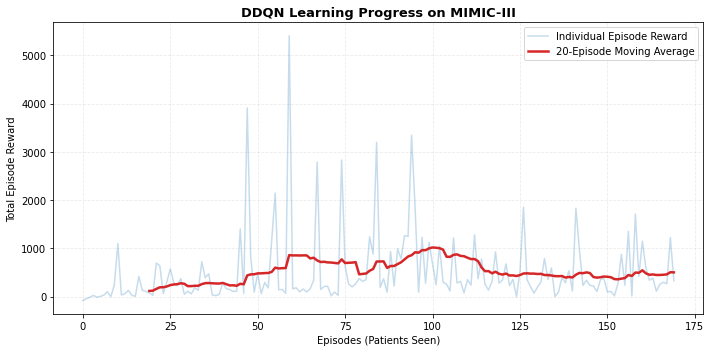

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_trend(episodic_returns, ma_window=20):
    """
    episodic_returns: list or 1D array of total reward per episode
    ma_window: moving-average window length
    """
    rewards = np.asarray(episodic_returns, dtype=np.float32)

    plt.figure(figsize=(10, 5))

    # Raw episode rewards
    plt.plot(
        rewards,
        alpha=0.25,
        color="tab:blue",
        label="Individual Episode Reward",
    )

    # Moving average (learning trend)
    if rewards.size >= ma_window:
        kernel = np.ones(ma_window) / ma_window
        ma = np.convolve(rewards, kernel, mode="valid")
        plt.plot(
            np.arange(ma_window - 1, rewards.size),
            ma,
            color="tab:red",
            lw=2.5,
            label=f"{ma_window}-Episode Moving Average",
        )

    plt.title("DDQN Learning Progress on MIMIC-III", fontsize=13, fontweight="bold")
    plt.xlabel("Episodes (Patients Seen)")
    plt.ylabel("Total Episode Reward")
    plt.grid(alpha=0.25, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_trend(returns)


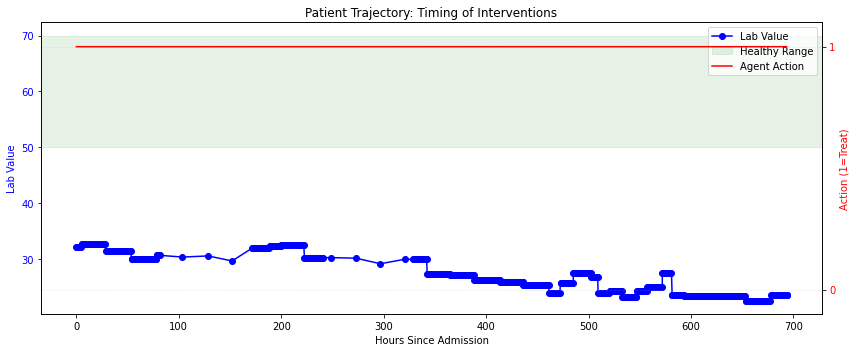

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_patient_trajectory(q_model, env, lab_index=0, time_index=1):
    device = next(q_model.parameters()).device
    q_model.eval()

    # Reset env and select the current episode
    try:
        obs, _ = env.reset()
    except ValueError:
        obs = env.reset()

    episode = np.asarray(env.current_episode, dtype=np.float32)

    # Extract lab + time from the episode
    vals = episode[:, lab_index]
    times = episode[:, time_index]

    # Predict actions for each timestep in the episode
    with torch.no_grad():
        ep_t = torch.as_tensor(episode, dtype=torch.float32, device=device)  # (T, obs_dim)
        q_vals = q_model(ep_t)                                               # (T, 2)
        actions = torch.argmax(q_vals, dim=1).cpu().numpy().astype(int)      # (T,)

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot Lab values
    ax1.plot(times, vals, color='blue', marker='o', label='Lab Value')
    ax1.axhspan(50, 70, color='green', alpha=0.1, label='Healthy Range')
    ax1.set_xlabel("Hours Since Admission")
    ax1.set_ylabel("Lab Value", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Plot Agent actions on secondary axis
    ax2 = ax1.twinx()
    ax2.step(times, actions, color='red', where='post', label='Agent Action')
    ax2.set_ylabel("Action (1=Treat)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_yticks([0, 1])
    ax2.set_ylim(-0.1, 1.1)

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title("Patient Trajectory: Timing of Interventions")
    plt.grid(alpha=0.2, linestyle='--')
    plt.tight_layout()
    plt.show()

# Call it with your trained Q-network
plot_patient_trajectory(q_model, env)


In [35]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(rewards, window=10):
    rewards = np.asarray(rewards, dtype=np.float32)

    plt.figure(figsize=(10, 5))

    # Raw rewards
    plt.plot(
        rewards,
        alpha=0.3,
        color="tab:blue",
        label="Raw Episode Reward",
    )

    # Moving average
    if rewards.size >= window:
        kernel = np.ones(window) / window
        avg_rewards = np.convolve(rewards, kernel, mode="valid")
        plt.plot(
            np.arange(window - 1, rewards.size),
            avg_rewards,
            color="tab:red",
            linewidth=2.5,
            label=f"Moving Average ({window})",
        )

    plt.title("Learning Curve: Agent Performance over Episodes", fontweight="bold")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(alpha=0.25, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()


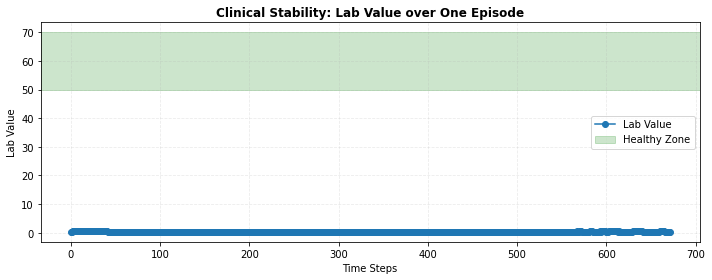

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_clinical_stability(q_model, env, lab_index=0):
    device = next(q_model.parameters()).device
    q_model.eval()

    # Reset environment (Gymnasium-safe)
    try:
        obs, _ = env.reset()
    except ValueError:
        obs = env.reset()

    obs = np.asarray(obs, dtype=np.float32)

    lab_history = []
    done = False

    while not done:
        # Prepare observation
        obs_t = torch.as_tensor(obs[None, :], dtype=torch.float32, device=device)

        # Select action via Q-network
        with torch.no_grad():
            q_vals = q_model(obs_t)                  # (1, 2)
            action = int(torch.argmax(q_vals, dim=1).item())

        # Step environment
        obs, reward, terminated, truncated, _ = env.step(action)
        obs = np.asarray(obs, dtype=np.float32)

        # Track lab value
        lab_history.append(obs[lab_index])

        done = terminated or truncated

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(lab_history, marker='o', linestyle='-', label='Lab Value')
    plt.axhspan(50, 70, color='green', alpha=0.2, label='Healthy Zone')

    plt.title("Clinical Stability: Lab Value over One Episode", fontweight="bold")
    plt.xlabel("Time Steps")
    plt.ylabel("Lab Value")
    plt.grid(alpha=0.25, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_clinical_stability(q_model, env)


IndexError: index 1 is out of bounds for axis 0 with size 1

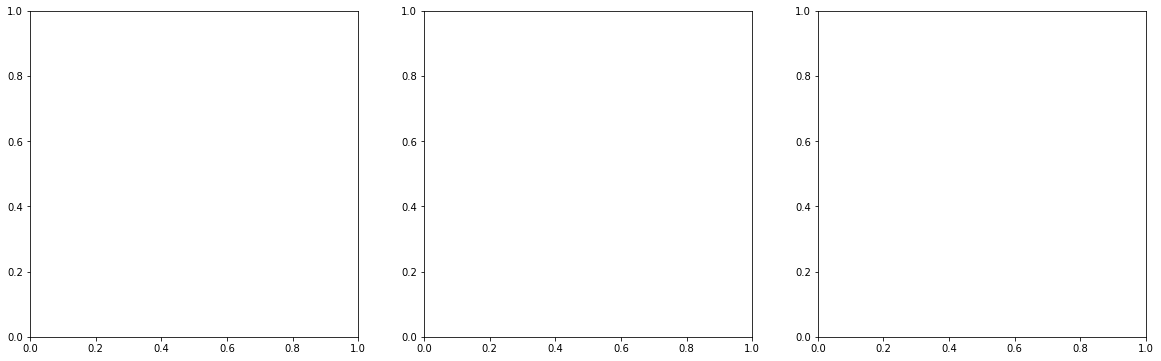

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def generate_professional_results(
    q_model,
    env,
    episodes,
    lab_index=0,
    time_index=1,
    hr_index=2,
    map_index=3,
    spo2_index=4,
    max_eps_for_safety=100,
    time_in_minutes=True,          # IMPORTANT: set True if episodes store minutes (0..2880)
    policy_grid_hours=48,          # display horizon in hours
):
    """
    Produces:
      1) Q-values bar at a representative state (median context)
      2) Safety / compliance pie using *clinical thresholds* (aligned with env definition)
      3) Policy map: Lab vs Time (hours) at fixed median context

    Key fixes:
      - Uses env normalisation if available (avoids plotting/model mismatch).
      - Safety uses clinical definition (not a lab-only percentile band).
      - Consistent time units: plot in hours, model input in minutes if configured.
    """

    if episodes is None or len(episodes) == 0:
        print("Error: No episodes found to analyze.")
        return

    device = next(q_model.parameters()).device
    q_model.eval()

    # ------------------------------------------------------------
    # 1) Canonical normalisation: prefer env's normalisation
    # ------------------------------------------------------------
    def _normalize_with_env(raw_batch: np.ndarray) -> np.ndarray:
        """
        raw_batch shape (N,5) in RAW units.
        Tries to call env's normaliser; otherwise falls back.
        """
        raw_batch = raw_batch.astype(np.float32, copy=False)

        # Try common env hooks
        if hasattr(env, "_get_normalized_obs"):
            try:
                return env._get_normalized_obs(raw_batch)
            except TypeError:
                # some env versions normalize a single obs; vectorise
                return np.vstack([env._get_normalized_obs(r[None, :])[0] for r in raw_batch])

        if hasattr(env, "normalize_obs"):
            return env.normalize_obs(raw_batch)

        # Fallback (ONLY if you cannot access env normalisation)
        # NOTE: update denominators to match training if needed.
        norm = np.zeros_like(raw_batch, dtype=np.float32)
        norm[:, lab_index]  = np.clip(raw_batch[:, lab_index] / 60.0, 0, 1)
        # time normalisation: minutes(0..2880) or hours(0..48)
        if time_in_minutes:
            norm[:, time_index] = np.clip(raw_batch[:, time_index] / (policy_grid_hours * 60.0), 0, 1)
        else:
            norm[:, time_index] = np.clip(raw_batch[:, time_index] / policy_grid_hours, 0, 1)
        norm[:, hr_index]   = np.clip(raw_batch[:, hr_index] / 150.0, 0, 1)
        norm[:, map_index]  = np.clip(raw_batch[:, map_index] / 130.0, 0, 1)
        norm[:, spo2_index] = np.clip(raw_batch[:, spo2_index] / 100.0, 0, 1)
        return norm

    # ------------------------------------------------------------
    # 2) Batched greedy action selection
    # ------------------------------------------------------------
    def predict_actions(obs_np: np.ndarray, batch_size: int = 65536) -> np.ndarray:
        n = obs_np.shape[0]
        actions = np.empty((n,), dtype=np.int64)
        for i in range(0, n, batch_size):
            x = torch.as_tensor(obs_np[i:i + batch_size], dtype=torch.float32, device=device)
            with torch.no_grad():
                q = q_model(x)
                a = torch.argmax(q, dim=1)
            actions[i:i + batch_size] = a.detach().cpu().numpy()
        return actions

    # ------------------------------------------------------------
    # 3) Clinical "healthy" definition (RAW units) — must match env.step
    # ------------------------------------------------------------
    def is_healthy_raw(lab, hr, map_, spo2) -> np.ndarray:
        lab_ok  = (lab >= 22.0) & (lab <= 29.0)
        hr_ok   = (hr  >= 60.0) & (hr  <= 100.0)
        map_ok  = (map_>= 65.0) & (map_<= 100.0)
        spo2_ok = (spo2 >= 92.0)
        return lab_ok & hr_ok & map_ok & spo2_ok

    # ------------------------------------------------------------
    # Gather dataset-wide raw distributions
    # ------------------------------------------------------------
    def _cat(idx):
        return np.concatenate([np.asarray(ep, dtype=np.float32)[:, idx] for ep in episodes])

    all_labs = _cat(lab_index)
    all_times = _cat(time_index)
    all_hrs = _cat(hr_index)
    all_maps = _cat(map_index)
    all_spo2 = _cat(spo2_index)

    # Representative context (medians)
    ctx_lab  = float(np.median(all_labs)) if all_labs.size else 28.0
    ctx_time = float(np.median(all_times)) if all_times.size else (12.0 * 60.0 if time_in_minutes else 12.0)
    ctx_hr   = float(np.median(all_hrs)) if all_hrs.size else 80.0
    ctx_map  = float(np.median(all_maps)) if all_maps.size else 80.0
    ctx_spo2 = float(np.median(all_spo2)) if all_spo2.size else 98.0

    # For display: convert ctx_time into hours
    ctx_time_hours = ctx_time / 60.0 if time_in_minutes else ctx_time

    # ------------------------------------------------------------
    # Figure layout
    # ------------------------------------------------------------
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # ============================================================
    # PLOT 1: Q-Value confidence at representative clinical state
    # ============================================================
    raw_state = np.array([[ctx_lab, ctx_time, ctx_hr, ctx_map, ctx_spo2]], dtype=np.float32)
    obs_state = _normalize_with_env(raw_state)

    with torch.no_grad():
        q_vals = q_model(torch.as_tensor(obs_state, dtype=torch.float32, device=device)).detach().cpu().numpy()[0]

    axs[0].bar(["Monitor", "Treat"], q_vals)
    axs[0].axhline(0, color="black", lw=1)
    axs[0].set_title(
        f"Q-Values at Representative State\n"
        f"Lab {ctx_lab:.1f} | Time {ctx_time_hours:.1f}h | HR {ctx_hr:.0f} | MAP {ctx_map:.0f} | SpO₂ {ctx_spo2:.0f}%",
        fontweight="bold",
    )
    axs[0].set_ylabel("Expected Future Reward (Q-Value)")
    axs[0].grid(axis="y", alpha=0.25, linestyle="--")

    # ============================================================
    # PLOT 2: Safety / compliance using clinical thresholds
    # ============================================================
    eps_subset = episodes[:max_eps_for_safety]

    states_list = []
    for ep in eps_subset:
        ep = np.asarray(ep, dtype=np.float32)
        # Ensure shape (T,5)
        if ep.ndim != 2 or ep.shape[1] < 5:
            continue
        states_list.append(ep[:, [lab_index, time_index, hr_index, map_index, spo2_index]])

    if len(states_list) == 0:
        axs[1].text(0.5, 0.5, "No valid episodes", ha="center", va="center")
        axs[1].set_title("Clinical Safety Compliance", fontweight="bold")
    else:
        states = np.concatenate(states_list, axis=0)  # (N,5) raw
        lab = states[:, 0]
        hr = states[:, 2]
        map_ = states[:, 3]
        spo2 = states[:, 4]

        healthy = is_healthy_raw(lab, hr, map_, spo2)   # boolean mask (N,)
        n_healthy = int(healthy.sum())
        n_unhealthy = int((~healthy).sum())

        # Greedy policy actions on all states (for confusion breakdown)
        actions = predict_actions(_normalize_with_env(states))

        # Define positives: unhealthy => should Treat(1)
        should_treat = ~healthy

        TP = int(((actions == 1) & should_treat).sum())   # treat when needed
        FN = int(((actions == 0) & should_treat).sum())   # missed treatment
        TN = int(((actions == 0) & healthy).sum())        # correct monitor
        FP = int(((actions == 1) & healthy).sum())        # over-treatment

        # Pie: correct decisions vs errors (or tailor to what you want)
        # Here: show TN vs FP among healthy (specificity view), plus FN vs TP among unhealthy (sensitivity view)
        # If you prefer a single pie, use [TP+TN, FP+FN].
        labels = ["Correct Monitor (TN)", "Over-Treatment (FP)", "Treat When Needed (TP)", "Missed Treatment (FN)"]
        values = [TN, FP, TP, FN]

        axs[1].pie(
            values,
            labels=labels,
            autopct="%1.1f%%",
            startangle=90,
        )
        axs[1].set_title(
            "Clinical Safety Compliance (Aligned with env thresholds)",
            fontweight="bold"
        )

        # Small text box with key rates
        sens = TP / max(TP + FN, 1)
        spec = TN / max(TN + FP, 1)
        axs[1].text(
            0.0, -1.2,
            f"Counts: Healthy={n_healthy}, Unhealthy={n_unhealthy}\n"
            f"Sensitivity (TPR)={sens:.3f} | Specificity (TNR)={spec:.3f}\n"
            f"FP rate among healthy={FP/max(n_healthy,1):.3f} | FN rate among unhealthy={FN/max(n_unhealthy,1):.3f}",
            ha="center", va="center", fontsize=10
        )

    # ============================================================
    # PLOT 3: Policy Map (Lab vs Time) at fixed median context
    # ============================================================
    v_min, v_max = np.percentile(all_labs, [5, 95]) if all_labs.size else (10.0, 50.0)
    lab_vals = np.linspace(v_min, v_max, 90)

    # Build time axis in HOURS for display
    hours = np.linspace(0, policy_grid_hours, 90)
    # Convert to env units for model input if needed
    time_vals_raw = hours * 60.0 if time_in_minutes else hours

    V, H = np.meshgrid(lab_vals, hours)
    n = V.size

    raw_grid = np.c_[
        V.ravel(),
        time_vals_raw.repeat(len(lab_vals)),   # aligns with H.ravel ordering
        np.full(n, ctx_hr, dtype=np.float32),
        np.full(n, ctx_map, dtype=np.float32),
        np.full(n, ctx_spo2, dtype=np.float32),
    ].astype(np.float32)

    Z = predict_actions(_normalize_with_env(raw_grid)).reshape(V.shape)

    cp = axs[2].contourf(V, H, Z, cmap="RdYlGn_r", alpha=0.65)
    axs[2].set_title(
        "Learned Policy Map (Lab vs Time)\n"
        f"Context: HR {ctx_hr:.0f}, MAP {ctx_map:.0f}, SpO₂ {ctx_spo2:.0f}%",
        fontweight="bold",
    )
    axs[2].set_xlabel("Lab Value")
    axs[2].set_ylabel("Hours Since Admission")
    cbar = fig.colorbar(cp, ax=axs[2], ticks=[0, 1])
    cbar.set_ticklabels(["Monitor", "Treat"])
    cbar.set_label("Action")

    plt.tight_layout()
    plt.show()


# Usage:
generate_professional_results(q_model, env, episodes, time_in_minutes=True)
